In [107]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Dropout, Flatten

from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter)
from dataclasses import dataclass

In [108]:
#import libs to resize and read files
import cv2
import os
import matplotlib.pyplot as plt
from PIL import Image

In [109]:
from pathlib import Path

In [110]:
#######################################
# List all files in the folder
#######################################
files_x = list(map(str, filter(lambda file: file.is_file(), Path("C:/temp/AR_out").rglob('*'))))

In [111]:
image_resized_list = []
#######################################
# resize all files
#######################################
for file in files_x:
    # read image
    img = cv2.imread(file, cv2.IMREAD_UNCHANGED)

    # Set Scale
    scale_percent = 10 
    width = int(img.shape[1] * scale_percent / 100)
    height = int(img.shape[0] * scale_percent / 100)
    dimension = (width, height)

    # resize image
    resized = cv2.resize(img, dimension, interpolation = cv2.INTER_AREA)

    #save an array
    image_resized_list.append(resized)
 

In [112]:
# Convert the list to a numpy array
image_resized_array = np.array(image_resized_list)

# Get the number of images and the dimensions of each image
num_images, height, width, num_channels = image_resized_array.shape

# Reshape the array into a 2D array where each row is a vectorized image
data_2d = image_resized_array.reshape(num_images, -1)  # -1 is a placeholder that tells numpy to compute the size of this dimension

In [113]:
mean_vector = np.mean(data_2d, axis=0)

In [114]:
# Center the data by subtracting the mean
centered_data = data_2d - mean_vector

In [115]:
covariance_matrix = np.dot(centered_data.T, centered_data) / (num_images - 1)

In [116]:
covariance_matrix = np.cov(data_2d, rowvar=False)


import matplotlib.pyplot as plt
import seaborn as sns  # Optional, for better visualization

# Display a heatmap of the covariance matrix
plt.figure(figsize=(10, 10))
sns.heatmap(covariance_matrix, cmap='coolwarm', fmt='.2f')
plt.show()

In [117]:
eigenvalues, eigenvectors = np.linalg.eigh(covariance_matrix)

In [118]:
# Get the indices that would sort the eigenvalues in descending order
sorted_indices = np.argsort(eigenvalues)[::-1]

# Sort the eigenvalues and eigenvectors
sorted_eigenvalues = eigenvalues[sorted_indices]
sorted_eigenvectors = eigenvectors[:, sorted_indices]


In [119]:
total_variance = np.sum(sorted_eigenvalues)

In [120]:
cumulative_variance = np.cumsum(sorted_eigenvalues)

In [121]:
num_eigenvectors_to_retain = np.argmax(cumulative_variance / total_variance >= 0.99) + 1
print (num_eigenvectors_to_retain)
#num_eigenvectors_to_retain = 500

748


In [122]:
# Select the top eigenvectors to retain 99% of the variance
top_eigenvectors = sorted_eigenvectors[:, :num_eigenvectors_to_retain]


# Project the centered data onto the selected eigenvectors
projected_data = np.dot(centered_data, top_eigenvectors)

In [123]:
##############################################################################
#Making a test with a orignal, resized and projected image
##############################################################################

In [124]:
index = 2034  # Index of the image you want to select
source_image = cv2.imread(files_x[index], cv2.IMREAD_UNCHANGED) 
resized_image = image_resized_array[index]
original_image = image_resized_array[index]

In [125]:
projected_representation = projected_data[index]
reconstructed_image_data = np.dot(projected_representation, top_eigenvectors.T)

In [126]:
reconstructed_image = reconstructed_image_data.reshape(height, width, num_channels)
reconstructed_image = np.clip(reconstructed_image, 0, 255).astype(np.uint8)


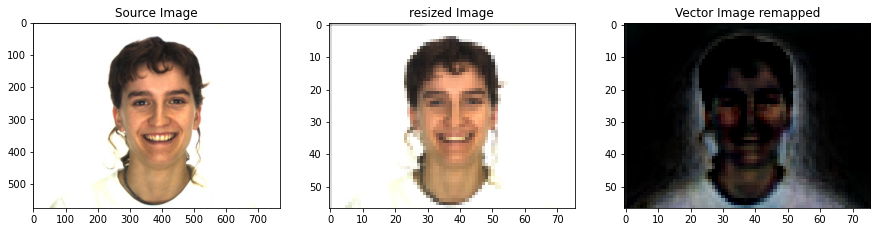

In [127]:
plt.figure(figsize=(15, 5))  # Adjust the figure size to accommodate three images

# Display source image
plt.subplot(1, 3, 1)  # 1 row, 3 columns, 1st subplot
plt.imshow(cv2.cvtColor(source_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB if necessary
plt.title('Source Image')

# Display original image
plt.subplot(1, 3, 2)  # 1 row, 3 columns, 2nd subplot
plt.imshow(cv2.cvtColor(resized_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB if necessary
#axs[1].imshow(resized_image)
plt.title('resized Image')

# Display reconstructed image
plt.subplot(1, 3, 3)  # 1 row, 3 columns, 3rd subplot
plt.imshow(cv2.cvtColor(reconstructed_image, cv2.COLOR_BGR2RGB))  # Convert BGR to RGB if necessary
plt.title('Vector Image remapped')

plt.show()